In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run imports.py

In [3]:
ds = cifar10.CIFAR10()
net = cifar10.Network()

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# ds.calc_performance(net, tqdm=tqdm)

In [6]:
# import mnist

import torch
from torch import nn
import numpy as np
import util

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [7]:
from mnist import MNIST

In [8]:
def intercept(v1, g1, v2, g2):
    '''
    from: https://math.stackexchange.com/questions/1036959/midpoint-of-the-shortest-distance-between-2-rays-in-3d
    '''
    def dot(a, b):
        return (a*b).sum(dim=-1)
    
    a, b, c, d = v1, g1, v2, g2
    
    bd = dot(b, d)
    ad = dot(a, d)
    bc = dot(b, c)
    cd = dot(c, d) 
    ab = dot(a, b)
    
    s = (bd*(ad-bc)-ad*cd)/(bd**2.-1.)
    t = (bd*(cd-ad)-bc*ab)/(bd**2.-1.)
    
    return (a+c+b*t[:, None]+d*s[:, None])/2.

def intercept(v1, g1, v2, g2):
    '''
    from: https://math.stackexchange.com/questions/3242011/finding-the-closest-two-points-on-two-lines-in-n-dimensions
    '''
    
    bs = v1.shape[:-1]
    def dot(a, b):
        return (a*b).sum(dim=-1)
    
    g1 = g1/g1.norm(dim=-1, keepdim=True)
    g2 = g2/g2.norm(dim=-1, keepdim=True)
    
    a, b, c, d = v1, g1, v2, g2
    
    # Ax = B
    A = torch.zeros(*bs, 2, 2)
    B = torch.zeros(*bs, 2)
    A[..., 0, 0] = b.norm(dim=-1)**2.
    A[..., 0, 1] = -dot(b, d)
    A[..., 1, 0] = -dot(b, d)
    A[..., 1, 1] = d.norm(dim=-1)**2.
    
    
    B[..., 0] = -dot(a-c, b)
    B[..., 1] = dot(a-c, d)
    
#     print(A)
#     print(torch.matrix_rank(A))
#     print(A.det())
#     print(A.inverse())
    
    st = (A.inverse()@B[..., None])[..., 0]
    s, t = st[..., 0], st[..., 1]
    
    # TODO clip s, t to 0 as lower limit
    
#     if s<0 or t<0:
#         print('st ', s,t)
    
    return (a+c+b*s[..., None]+d*t[..., None])/2., s, t

In [9]:
from functions import *

In [10]:
def fn_quad(x):
    return x.norm(dim=-1)**2

def fg_fn(x, fn):
    x = x.detach().requires_grad_()
    loss = fn(x)
    loss.backward()
    return loss, x.grad

fn = rosenbrock

In [11]:
def calc_sgd_trajectory(x, steps, lr=1e-1):
    traj = [] # trajectory
    traj_grad = []

    x.requires_grad_()

    opt = torch.optim.SGD([x], lr=lr)
    for _ in range(steps):
        loss = fn(x)

        opt.zero_grad()
        loss.backward()
        traj.append(x.detach().clone())
        traj_grad.append(x.grad.detach().clone())
        opt.step()

    traj = torch.stack(traj)
    traj_grad = torch.stack(traj_grad)
    return traj, traj_grad

def calc_eps_intercept_trajectory(x, steps, eps=1e-1):
    traj = [] # trajectory
    traj_grad = []

    x1 = x
    
    for _ in range(steps):
        
        x2 = x1 + eps*torch.randn_like(x1)
        f1, g1 = fg_fn(x1, fn)
        f2, g2 = fg_fn(x2, fn)
        x3, _, _ = intercept(x1.detach(), -g1.detach(), x2.detach(), -g2.detach())
        
        traj.append(torch.stack([x1, x2]).detach().clone())
        traj_grad.append(torch.stack([g1, g2]).detach().clone())
        
        x1 = x3

    traj = torch.stack(traj)
    traj_grad = torch.stack(traj_grad)
    return traj, traj_grad

In [12]:
def plot_contour(fn, xmin, ymin, xmax, ymax):
    
    x1 = torch.linspace(xmin, xmax, 100)
    x2 = torch.linspace(ymin, ymax, 100)
    x1, x2 = torch.meshgrid(x1, x2)
    x = torch.stack([x1, x2], dim=-1)
    z = fn(x)

    plt.contourf(x1, x2, z, levels=100)
    plt.colorbar()

def plot_sgd_traj(traj, traj_grad, s=10, glen=.01):
    plt.scatter(*traj.T.numpy(), c='g', s=s)

    for v, g in zip(traj, traj_grad):
        a = torch.stack([v, v-glen*g])
        plt.plot(*a.numpy().T, c='r')
        
def plot_eps_intercept_traj(traj, traj_grad, s=10, glen=.01):
    plt.scatter(*traj[:, 0].T.numpy(), c='g', s=s)
    plt.scatter(*traj[:, 1].T.numpy(), c='b', s=s)

    for vs, gs in zip(traj, traj_grad):
        for v, g in zip(vs, gs):
            a = torch.stack([v, v-glen*g])
            plt.plot(*a.numpy().T, c='r')

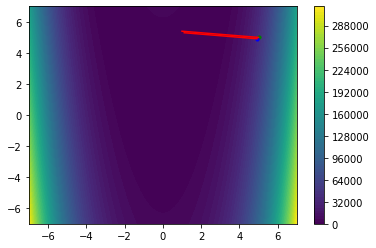

In [28]:

a = 7

x = torch.tensor([5., 5.])

# plot_contour(fn, -a, -a, a, a)
# traj, traj_grad = calc_sgd_trajectory(x, 10, lr=1e-6)
# plot_sgd_traj(traj, traj_grad, s=10, glen=1e-5)
# plt.show()

plot_contour(fn, -a, -a, a, a)
traj, traj_grad = calc_eps_intercept_trajectory(x, 2, eps=1e-1)
plot_eps_intercept_traj(traj, traj_grad, s=10, glen=1e-4)
plt.xlim(-a, a); plt.ylim(-a, a)
plt.show()

In [15]:
torch.manual_seed(1)
v1 = torch.randn(16, 2)
g1 = torch.randn(16, 2)
v2 = torch.randn(16, 2)
g2 = torch.randn(16, 2)

# v1 = torch.tensor([[0, 0.]])
# g1 = torch.tensor([[1, 0.]])
# v2 = torch.tensor([[0, -2.]])
# g2 = torch.tensor([[1, 2.]])/10.


In [16]:
it = intercept(v1, g1, v2, g2)

TypeError: scatter() got multiple values for argument 'marker'

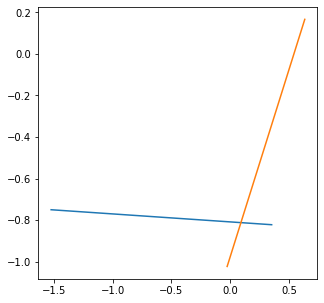

In [17]:

for i in range(len(v1)):
    plt.figure(figsize=(5, 5))
#     plt.quiver(*v1[i], *g1[i], scale=5)
#     plt.quiver(*v2[i], *g2[i], scale=5)
    
    plt.plot(*torch.stack([v1[i], v1[i]+g1[i]]).T)
    plt.plot(*torch.stack([v2[i], v2[i]+g2[i]]).T)
    plt.scatter(*it[i], marker='x', c='r', s=100)
    # plt.scatter(*it1[i], marker='x', c='g', s=100)

    plt.xlim(-4, 4); plt.ylim(-4, 4)
    plt.show()

In [13]:
def step_intercept_epsilon(x1, fn, eps=1e-2):
    x2 = x1 + eps*torch.randn_like(x1)
    f1, g1 = fg_fn(x1, fn)
    f2, g2 = fg_fn(x2, fn)
    x3 = intercept(x1.detach(), -g1.detach(), x2.detach(), -g2.detach())
    return x3

def step(x):
    fx = func(x)
    gx = grad(x)
    
    t = 1e-5
    while func(x-t*gx)<fx:
        t *= 2
    v1 = x-t/2.*gx
    v2 = x-t*gx
    v2 = v2+torch.randn_like(v2)*.1
    
    g1 = grad(v1)
    g2 = grad(v2)
    
    v3 = intercept(v1, -g1, v2, -g2)
    
    # plt.plot(*torch.stack([v1, (v1-g1/10.)]).T)
    # plt.plot(*torch.stack([v2, (v2-g2/10.)]).T)

    # plt.scatter(*v3, marker='x', c='r', s=100)
        

In [6]:
x1 = (torch.randn(100)*100).requires_grad_()
x2 = (torch.randn(2)*100).requires_grad_()

# f1, g1 = fg_quad(x1)
# f2, g2 = fg_quad(x2)

In [7]:
x1 = (torch.randn(100)).requires_grad_()
x3 = step_intercept_epsilon(x1, fn_quad, eps=1e-2)

In [14]:
# TODO the more parralel the two grad directions, the less you trust my intersection estimate
# use convex combination of (intersection estimate) and (mean of the two base points)

In [280]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(8, 8, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(8, 8, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 8, 3, padding=1),
            nn.MaxPool2d(3),
        )
        self.classification = nn.Sequential(
            nn.Linear(32, 10),
            nn.LogSoftmax(dim=-1),
        )
    def forward(self, x):
        x = self.seq(x)
        x = x.reshape(len(x), -1)
        x = self.classification(x)
        return x

In [141]:
ds = mnist.MNIST()
dataset = mnist

ds = cifar10.CIFAR10()
dataset = cifar10

Files already downloaded and verified
Files already downloaded and verified


In [19]:
net = dataset.Network()
opt = torch.optim.Adam(net.parameters(), lr=1e-2)
print(np.sum([p.numel() for p in net.parameters()]))

# net(torch.randn(1,1,28,28))

v = nn.utils.parameters_to_vector(net.parameters()).detach().requires_grad_()

2306


In [29]:
data = {}

## MNIST Adam

In [93]:
net = dataset.Network()
opt = torch.optim.Adam(net.parameters(), lr=1e-2)

accu = util.Accumulator()

for epoch_idx in range(1):
    for x, y in tqdm(ds.dl_train):
        yp = net(x)
        loss = ds.loss_fn(yp, y)
        acc = (yp.argmax(dim=-1)==y).sum().item()/len(x)

        opt.zero_grad()
        loss.backward()
        opt.step()
        
        wnorm = nn.utils.parameters_to_vector(net.parameters()).norm()
        accu.append(loss_batch=loss.item(), acc_batch=acc, wnorm=wnorm.item())
        
data['adam'] = accu

  0%|          | 0/50 [00:00<?, ?it/s]

## MNIST SGD w/ Momentum

In [94]:
net = dataset.Network()
opt = torch.optim.SGD(net.parameters(), lr=3e-3, momentum=0.9)

accu = util.Accumulator()

for epoch_idx in range(1):
    for x, y in tqdm(ds.dl_train):
        yp = net(x)
        loss = ds.loss_fn(yp, y)
        acc = (yp.argmax(dim=-1)==y).sum().item()/len(x)

        opt.zero_grad()
        loss.backward()
        opt.step()

        wnorm = nn.utils.parameters_to_vector(net.parameters()).norm()
        accu.append(loss_batch=loss.item(), acc_batch=acc, wnorm=wnorm.item())
        
data['sgdm'] = accu

  0%|          | 0/50 [00:00<?, ?it/s]

In [256]:
vo = nn.utils.parameters_to_vector(net.parameters()).detach().requires_grad_()

In [257]:
fo, g = fg_fn_nn(vo, x, y)
fs = []

for t in tqdm(torch.logspace(-1, -3, 20)):
    f, _ = fg_fn_nn(vo+g*t, x, y)
    fs.append([t,f.item()])
fs.append([0, fo.item()])
for t in tqdm(-torch.logspace(-3, -1, 20)):
    f, _ = fg_fn_nn(vo+g*t, x, y)
    fs.append([t, f.item()])
fs = np.array(fs)

100%|██████████| 20/20 [00:03<00:00,  5.08it/s]


(0.1917508840560913, 3.0)

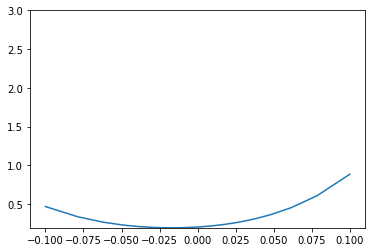

In [258]:
plt.plot(*fs.T)
plt.ylim(fs[:, 1].min(), 3)
# plt.xscale('symlog')

In [95]:
def step_epsilon(x1, x, y, net, opt, eps=1e-2):
    f1, g1 = fg_fn_nn(x1, x, y, net, opt)
    
    g1n = g1/g1.norm(dim=-1, keepdim=True)
    x2 = x1 + eps*torch.randn_like(x1)-g1n*eps

    f2, g2 = fg_fn_nn(x2, x, y, net, opt)
    x3, s, t = intercept(x1.detach(), -g1.detach(), x2.detach(), -g2.detach())
    return f1, x3, s, t

def step_smart(x1, x, y, t=1e-5):
    f1, g1 = fg_fn_nn(x1, x, y)
    
    ft, gt = fg_fn_nn(x1-t*g1, x, y)
    if ft<f1:
        while ft<f1:
            t *= 2.
            ft, gt = fg_fn_nn(x1-t*g1, x, y)
    elif ft>f1:
        while ft>f1:
            t /= 2.
            ft, gt = fg_fn_nn(x1-t*g1, x, y)
        t*=2.
        
    x2 = x1-t*g1
    x1 = x1-t/2.*g1
    
    f1, g1 = fg_fn_nn(x1, x, y)
    f2, g2 = fg_fn_nn(x2, x, y)
    x3 = intercept(x1.detach(), -g1.detach(), x2.detach(), -g2.detach())
    return f1, x3

In [96]:
def fg_fn_nn(v, x, y, net, opt):
    nn.utils.vector_to_parameters(v, net.parameters())
    opt.zero_grad()
    yp = net(x)
    loss = ds.loss_fn(yp, y)
    loss.backward()
    
    g = torch.cat([p.grad.flatten() for p in net.parameters()])
    return loss, g

## MNIST Two-Man-SGD

In [144]:
net = dataset.Network()
opt = torch.optim.Adam(net.parameters(), lr=1e-2)
v = nn.utils.parameters_to_vector(net.parameters()).detach().requires_grad_()

accu = util.Accumulator()

eps = 1e-3

for epoch_idx in range(2):
    for x, y in tqdm(ds.dl_train):
        f1, v2, s, t = step_epsilon(v, x, y, net, opt, eps)
        step_size = 0.
        
        # if 'step_size' in accu.keys() and (v2-v).norm()>accu['step_size'].mean()+accu['step_size'].std():
            # continue
        
        pv = v
        if s>0 and t>0:
            print(f'step size {(v2-v).norm():.04f}')
            step_size = (v2-v).norm().item()
            v = v2
        
        
        # f1, v = step_smart(v, x, y)
        # print('mean abs weight ', x1.abs().mean().item())
        
        yp = net(x)
        loss = ds.loss_fn(yp, y)
        acc = (yp.argmax(dim=-1)==y).sum().item()/len(x)
        print(f'{loss.item(): .03f}, {v.norm(dim=-1): .03f}')
        
        if 'loss_batch' in accu.keys() and loss.item()>accu['loss_batch'][-1].item():
            # goback
            v = pv

        
        if 'loss_batch' in accu.keys() and loss.item()>accu['loss_batch'][-1]+.2:
            print('DETECTED SPIKE')
            for i, (x, y) in enumerate(ds.dl_train):
                yp = net(x)
                loss = ds.loss_fn(yp, y)
                print(loss.item())
                if i==5:
                    break
            print('\n\n\n\n')
        
        wnorm = nn.utils.parameters_to_vector(net.parameters()).norm()
        accu.append(loss_batch=loss.item(), acc_batch=acc, wnorm=wnorm.item(), 
                    step_size=step_size)
        
data['2man'] = accu

  0%|          | 0/50 [00:00<?, ?it/s]

 2.311,  3.734
 2.307,  3.734
 2.310,  3.734
step size 0.0254
 2.307,  3.734
 2.307,  3.734
step size 0.0492
 2.304,  3.733
step size 0.0241
 2.312,  3.732
step size 0.0505
 2.307,  3.731
 2.306,  3.731
step size 0.0273
 2.304,  3.730
step size 0.0251
 2.304,  3.729
step size 0.0315
 2.307,  3.729
step size 0.0514
 2.306,  3.728
step size 0.0270
 2.303,  3.728
step size 0.0334
 2.305,  3.729
 2.305,  3.728
 2.305,  3.728
step size 0.0246
 2.304,  3.728
step size 0.0267
 2.305,  3.728
step size 0.0358
 2.308,  3.727
step size 0.0326
 2.304,  3.729
step size 0.0477
 2.304,  3.729
step size 0.0254
 2.303,  3.730
 2.305,  3.730
step size 0.0244
 2.304,  3.730
 2.302,  3.730
 2.303,  3.730
 2.304,  3.730
 2.305,  3.730
 2.304,  3.730
step size 0.0280
 2.304,  3.731
 2.303,  3.731
step size 0.0305
 2.302,  3.732
step size 0.0306
 2.300,  3.733
step size 0.0331
 2.300,  3.733
step size 0.0254
 2.300,  3.734
step size 0.0241
 2.299,  3.734
step size 0.0382
 2.297,  3.736
step size 0.0428
 2.29

  0%|          | 0/50 [00:00<?, ?it/s]

 2.289,  3.756
 2.289,  3.756
step size 0.0408
 2.285,  3.759
 2.294,  3.759
step size 0.0362
 2.287,  3.761
 2.289,  3.761
step size 0.0362
 2.286,  3.764
step size 0.0559
 2.281,  3.772
step size 0.0263
 2.284,  3.773
step size 0.0387
 2.279,  3.776
step size 0.0240
 2.269,  3.777
step size 0.0604
 2.282,  3.781
step size 0.0304
 2.279,  3.778
step size 0.0523
 2.275,  3.786
step size 0.0297
 2.269,  3.788
step size 0.0283
 2.266,  3.791
step size 0.0720
 2.258,  3.804
step size 0.1016
 2.262,  3.801
 2.268,  3.804
step size 0.1012
 2.255,  3.803
 2.269,  3.803
step size 0.0968
 2.269,  3.813
step size 0.0909
 2.261,  3.810
step size 0.0850
 2.256,  3.820
 2.239,  3.820
step size 0.1623
 2.252,  3.819
step size 0.0814
 2.248,  3.819
step size 0.0964
 2.249,  3.831
 2.248,  3.819
step size 0.0835
 2.247,  3.829
step size 0.1242
 2.234,  3.829
step size 0.0368
 2.269,  3.831
step size 0.0512
 2.276,  3.832
step size 0.1353
 2.274,  3.839
step size 0.2068
 2.254,  3.830
 2.304,  3.830
s

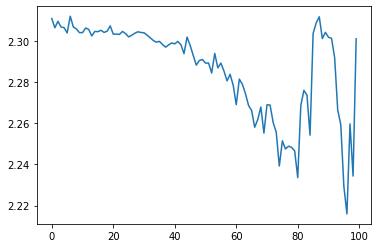

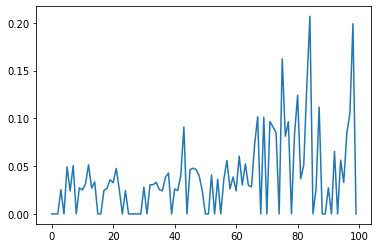

In [146]:
plt.plot(accu['loss_batch'])
plt.show()
plt.plot(accu['step_size'])

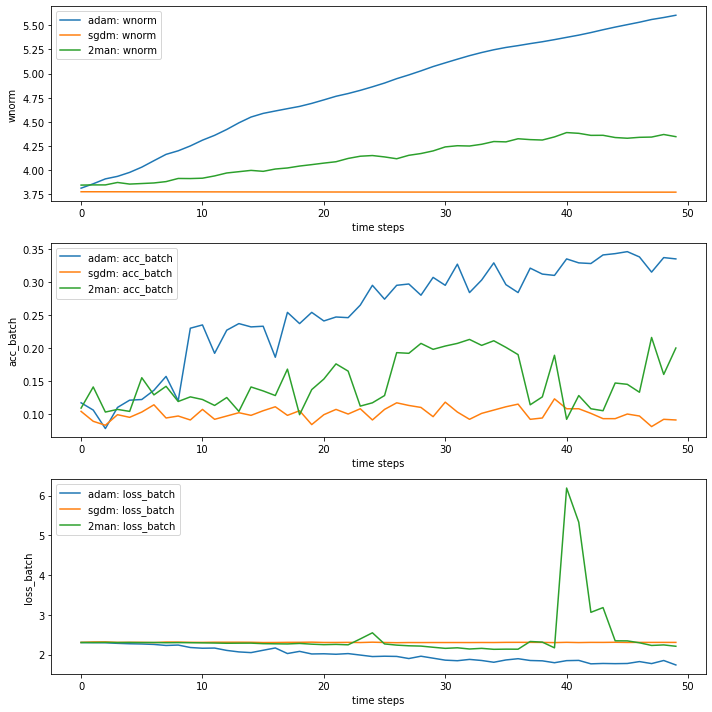

In [117]:
plt.figure(figsize=(10,10))
util.plot_accumulators(data)

array([2.30300999, 2.30057836, 2.29773331, 2.28252077, 2.27208185,
       2.26649904, 2.25515151, 2.22926569, 2.23919535, 2.17760682,
       2.15959048, 2.16377497, 2.10470271, 2.0668726 , 2.04922748,
       2.1085391 , 2.16638112, 2.02610731, 2.08067012, 2.0153296 ,
       2.0199852 , 2.00799465, 2.02447104, 1.9876132 , 1.95002329,
       1.95856082, 1.95329726, 1.90004361, 1.95859551, 1.90922701,
       1.859635  , 1.84512556, 1.87845254, 1.85103726, 1.80653441,
       1.86466706, 1.89585781, 1.85083461, 1.84235334, 1.79475951,
       1.84734476, 1.85333419, 1.76693904, 1.77614045, 1.77131689,
       1.77547204, 1.82347429, 1.77327907, 1.85058725, 1.73869884])

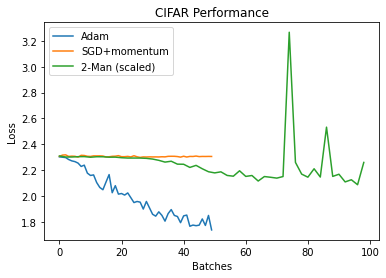

In [107]:
plt.plot(data['adam']['loss_batch'], label='Adam')
plt.plot(data['sgdm']['loss_batch'], label='SGD+momentum')
plt.plot(np.arange(len(data['2man']['loss_batch']))*2, 
         data['2man']['loss_batch'], label='2-Man (scaled)')
plt.title('CIFAR Performance'); plt.ylabel('Loss'); plt.xlabel('Batches')
plt.legend()

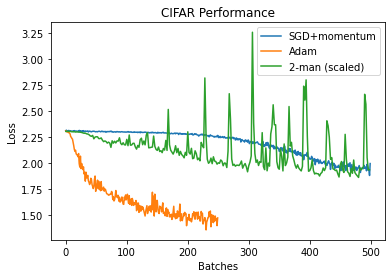

In [40]:
plt.plot(np.array(data['sgdm_meter_loss'].data)[:, 0], label='SGD+momentum')
plt.plot(np.array(data['adam_meter_loss'].data)[:, 0], label='Adam')
plt.plot(np.arange(250)*2, np.array(data['2mansgd_meter_loss'].data)[:, 0], label='2-man (scaled)')
plt.title('CIFAR Performance'); plt.ylabel('Loss'); plt.xlabel('Batches')
plt.legend()

# Combining Adam/SGD with momentum to the gradients (delta weights) for 2 man sgd

In [50]:
np.sum([p.numel() for p in net.parameters()])

2306

In [56]:
def set_grad(g, net):
    i = 0
    for p in net.parameters():
        if g is None:
            p.data = None
        else:
            gdata = g[i: i+p.numel()].reshape(p.shape)
            p.grad = gdata.clone()
    
set_grad(torch.zeros(2306), net)

In [60]:
net = dataset.Network()
# opt = torch.optim.Adam(net.parameters(), lr=1e-2)
opt = torch.optim.SGD(net.parameters(), lr=1, momentum=0.9)
# opt = torch.optim.SGD(net.parameters(), lr=1, momentum=0)
v = nn.utils.parameters_to_vector(net.parameters()).detach().requires_grad_()

meter_acc = metrics.AverageMeter(keep_verbose_stats=True)
meter_loss = metrics.AverageMeter(keep_verbose_stats=True)

eps = 1e-2

for epoch_idx in range(5):
    for x, y in tqdm(ds.dl_train):
        f1, v2, s, t = step_epsilon(v, x, y, net, opt, eps)
        nv = v
        if s>0 and t>0:
            nv = v2
        g = -(nv-v)
        
        set_grad(g, net)
        opt.step()
        opt.zero_grad()
        
        
        
        
        yp = net(x)
        loss = ds.loss_fn(yp, y)
        acc = (yp.argmax(dim=-1)==y).sum().item()/len(x)
        print(loss.item())

        meter_acc.update(acc, len(x))
        meter_loss.update(loss.item(), len(x))
    
data['2mansgd_meter_loss'] = meter_loss
data['2mansgd_meter_acc'] = meter_acc

  0%|          | 0/50 [00:00<?, ?it/s]

2.3124072551727295
2.305079698562622
2.300426959991455
2.3082163333892822
2.3035242557525635
2.30521821975708
2.3046319484710693
2.300846815109253
2.307983875274658
2.3099865913391113
2.3053438663482666
2.3066904544830322
2.3061087131500244
2.2977609634399414
2.299973726272583
2.3055291175842285


KeyboardInterrupt: 

# TODO: sample noise not randomly, but towards negative grad

# TODO: ignore intersection if line s or t values are negative
# (this means go away from the negative grad)